Step 1 
- Loaded and explored Jigsaw train.csv and all_data.csv (sample)
- Analyzed toxicity label distribution and comment lengths
- Added a binary toxic label for simplified classification
- Identified real ambiguous and obfuscated words for later use

In [38]:
# 📦 Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot styles
sns.set(style="whitegrid")
%matplotlib inline

 Load the Primary Dataset (train.csv)

In [39]:
# Load main Jigsaw Toxic dataset
train_df = pd.read_csv("data/train.csv")

# Show first few rows
print("Sample rows from train.csv:")
display(train_df.head())

# Show label columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print("Toxic label columns:", label_cols)

Sample rows from train.csv:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Toxic label columns: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


Label Distribution (Multi-label)

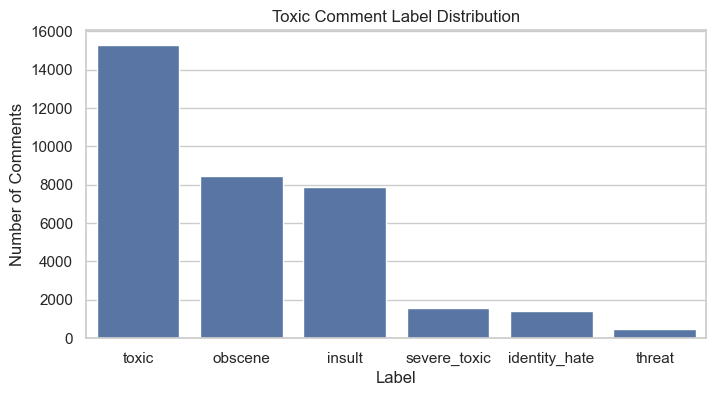

In [40]:
# Sum across label columns
label_counts = train_df[label_cols].sum().sort_values(ascending=False)

# Barplot of label frequencies
plt.figure(figsize=(8, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Toxic Comment Label Distribution")
plt.xlabel("Label")
plt.ylabel("Number of Comments")
plt.show()

Convert to Binary Toxic Label

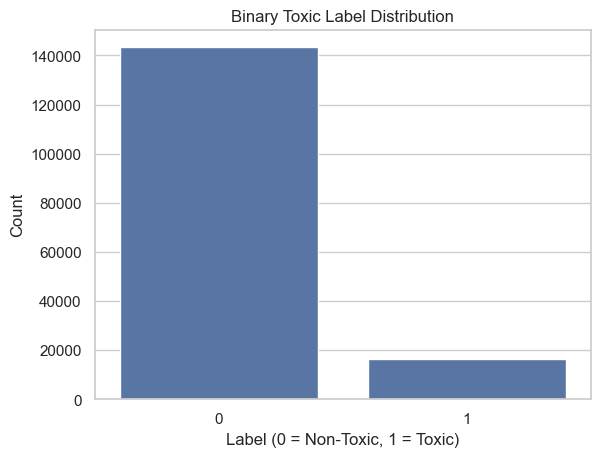

toxic_binary
0    143346
1     16225
Name: count, dtype: int64

In [41]:
# Add a binary label: toxic if any of the labels are 1
train_df['toxic_binary'] = (train_df[label_cols].sum(axis=1) > 0).astype(int)

# Distribution of binary label
sns.countplot(x='toxic_binary', data=train_df)
plt.title("Binary Toxic Label Distribution")
plt.xlabel("Label (0 = Non-Toxic, 1 = Toxic)")
plt.ylabel("Count")
plt.show()


# Show the count of toxic vs non-toxic comments
train_df['toxic_binary'].value_counts()

Comment Length Analysis

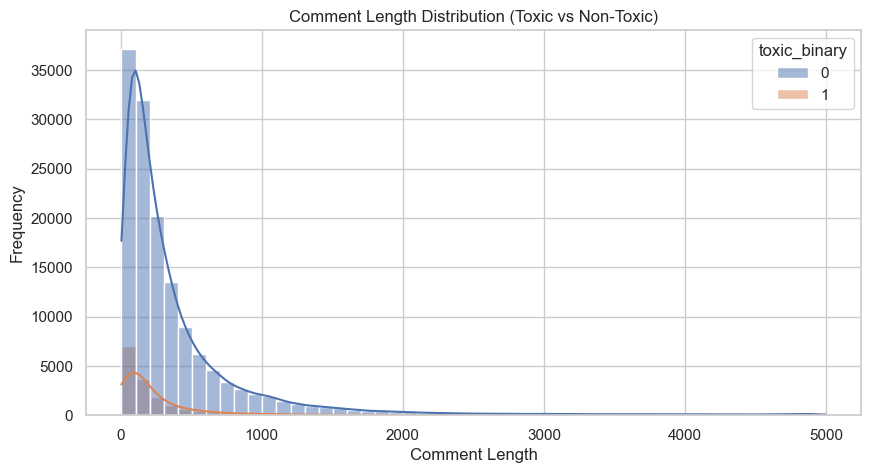

In [42]:
# Create a length feature
train_df['text_length'] = train_df['comment_text'].apply(len)

# Plot comment lengths by toxicity
plt.figure(figsize=(10, 5))
sns.histplot(data=train_df, x='text_length', hue='toxic_binary', bins=50, kde=True)
plt.title("Comment Length Distribution (Toxic vs Non-Toxic)")
plt.xlabel("Comment Length")
plt.ylabel("Frequency")
plt.show()

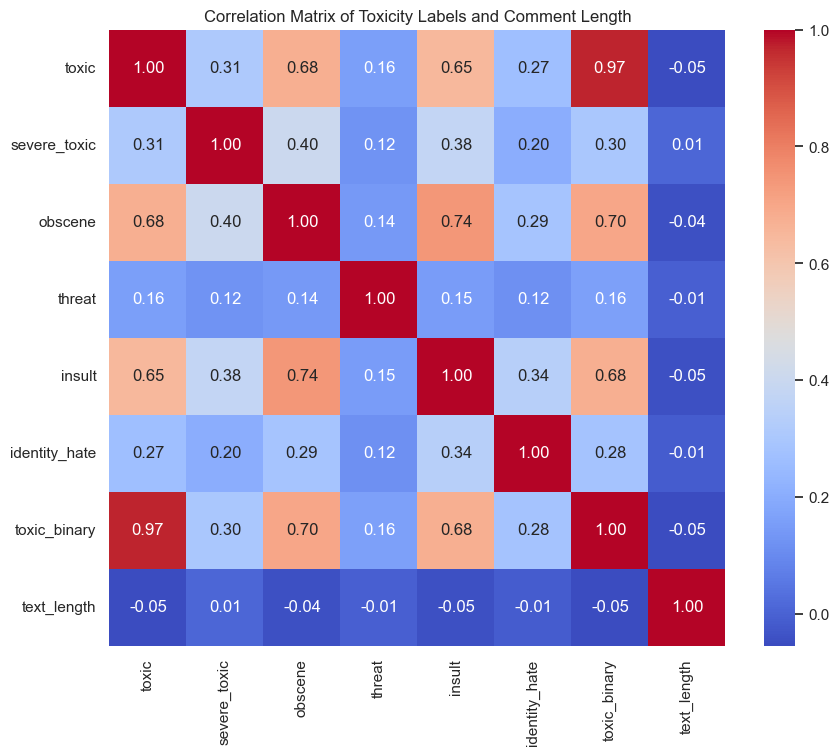

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create text length feature
train_df['text_length'] = train_df['comment_text'].apply(len)

# Include only numerical columns for correlation (e.g., toxicity labels and text_length)
correlation_columns = [col for col in train_df.columns if train_df[col].dtype in ['int64', 'float64']]
correlation_matrix = train_df[correlation_columns].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Toxicity Labels and Comment Length")
plt.show()

Ambiguous Words in Clean vs Toxic Context

In [44]:
# Words that often get flagged inappropriately
ambiguous_words = ['pussy', 'bitch', 'kill', 'bomb', 'gay']

for word in ambiguous_words:
    toxic_count = train_df[(train_df['toxic_binary'] == 1) & (train_df['comment_text'].str.contains(word, case=False))].shape[0]
    non_toxic_count = train_df[(train_df['toxic_binary'] == 0) & (train_df['comment_text'].str.contains(word, case=False))].shape[0]
    print(f"'{word}' — Toxic: {toxic_count} | Non-Toxic: {non_toxic_count}")



    #  here i have to check whether the distribution of these examples ambigous words accross different labels.  

'pussy' — Toxic: 157 | Non-Toxic: 20
'bitch' — Toxic: 849 | Non-Toxic: 60
'kill' — Toxic: 442 | Non-Toxic: 1631
'bomb' — Toxic: 55 | Non-Toxic: 390
'gay' — Toxic: 570 | Non-Toxic: 432


Load Jigsaw Unintended Bias Dataset (Sampled) - (Optional) can be used in later steps.

In [45]:
# Load a sample of the unintended bias dataset
bias_df = pd.read_csv("data/all_data.csv", nrows=100000)

# Show sample rows
print("Sample rows from all_data.csv (Unintended Bias):")
display(bias_df[['comment_text', 'toxicity']].head())

# Convert toxicity score to binary
bias_df['toxic_binary'] = (bias_df['toxicity'] > 0.5).astype(int)

# Check for Obfuscated Terms in Real-world Samples

# Look for obfuscated toxic words in bias dataset
obfuscated_terms = ['k1ll', 'b!tch', '@sshole', 'f@ggot', 'idi0t']

for word in obfuscated_terms:
    matches = bias_df[bias_df['comment_text'].str.contains(word, case=False)]
    print(f"'{word}' found in {matches.shape[0]} comments in all_data.csv")

Sample rows from all_data.csv (Unintended Bias):


,comment_text,toxicity
0,He got his money... now he lies in wait till a...,0.373134
1,Mad dog will surely put the liberals in mental...,0.605263
2,And Trump continues his lifelong cowardice by ...,0.666667
3,"""while arresting a man for resisting arrest"".\...",0.815789
4,Tucker and Paul are both total bad ass mofo's.,0.550000


'k1ll' found in 0 comments in all_data.csv
'b!tch' found in 1 comments in all_data.csv
'@sshole' found in 0 comments in all_data.csv
'f@ggot' found in 0 comments in all_data.csv
'idi0t' found in 3 comments in all_data.csv


Step 2
- Cleaned and preprocessed the text
- Created binary labels for toxicity
- Tokenized text using BERT tokenizer
- Split data into train, val, test
- Created 3 special evaluation sets:
  • ambiguous_validation_df
  • balanced_validation_df
  • adversarial_test_df
- Wrapped all into PyTorch Datasets and DataLoaders

In [46]:
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

# Show the count of toxic vs non-toxic comments
train_df['toxic_binary'].value_counts()

toxic_binary
0    143346
1     16225
Name: count, dtype: int64

In [47]:
# Define a function to clean text while keeping obfuscated symbols
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-z0-9\s@#$%&*!?]', '', text)  # Keep common obfuscation symbols
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    return text

# Apply cleaning
train_df['clean_text'] = train_df['comment_text'].astype(str).apply(clean_text)
for i in range(3):
    print(f"Original: {train_df['comment_text'][i]}")
    print(f"Cleaned:  {train_df['clean_text'][i]}")
    print("-" * 80)
train_df[['comment_text', 'clean_text']].head()

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Cleaned:  explanation why the edits made under my username hardcore metallica fan were reverted? they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now892053827
--------------------------------------------------------------------------------
Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Cleaned:  daww! he matches this background colour im seemingly stuck with thanks talk 2151 january 11 2016 utc
--------------------------------------------------------------------------------
Original: Hey man, I'm really not trying to edit war. It's just

,comment_text,clean_text
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww! he matches this background colour im see...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


Load the BERT tokenizer (bert-base-uncased)

In [48]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Split Datasets

In [49]:
from sklearn.model_selection import train_test_split

# 80% Train, 10% Validation, 10% Test
train_df, temp_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['toxic_binary'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['toxic_binary'],
    random_state=42
)

# Show counts for each set
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 127656
Validation: 15957
Test: 15958


Create Special Evaluation Sets

In [50]:
# Define common ambiguous terms that often cause false positives
ambiguous_words = ['pussy', 'bitch', 'gay', 'kill', 'bomb']

# Filter val_df to get samples containing any ambiguous term
def contains_ambiguous(text):
    return any(word in text for word in ambiguous_words)

# Apply filter to validation set
ambiguous_validation_df = val_df[val_df['clean_text'].apply(contains_ambiguous)]

print(f" ambiguous_validation_df created with {len(ambiguous_validation_df)} samples.")

 ambiguous_validation_df created with 436 samples.


In [51]:
# we have took this because to check false positive for label toxic - in later steps.

# Count available samples in each class
num_toxic = val_df[val_df['toxic_binary'] == 1].shape[0]
num_non_toxic = val_df[val_df['toxic_binary'] == 0].shape[0]

# Choose the smaller count
sample_size = min(num_toxic, num_non_toxic)

# Sample equally from both classes
toxic_samples = val_df[val_df['toxic_binary'] == 1].sample(n=sample_size, random_state=42)
non_toxic_samples = val_df[val_df['toxic_binary'] == 0].sample(n=sample_size, random_state=42)

# Combine and shuffle
balanced_validation_df = pd.concat([toxic_samples, non_toxic_samples]).sample(frac=1, random_state=42)

print(f"✅ Balanced validation set created with {len(balanced_validation_df)} samples (Toxic: {sample_size}, Non-Toxic: {sample_size})")

✅ Balanced validation set created with 3244 samples (Toxic: 1622, Non-Toxic: 1622)


In [52]:
# Load a sample of unintended bias dataset
bias_df = pd.read_csv("data/all_data.csv", usecols=['comment_text', 'toxicity'], nrows=100000)
bias_df['toxic_binary'] = (bias_df['toxicity'] > 0.5).astype(int)

# Obfuscated term filter
obfuscated_terms = ['k1ll', 'b!tch', '@sshole', 'f@ggot', 'idi0t']

def contains_obfuscated(text):
    return any(term in text.lower() for term in obfuscated_terms)

adversarial_test_df = bias_df[bias_df['comment_text'].apply(contains_obfuscated)]
print(f"Adversarial test set: {len(adversarial_test_df)} samples")

Adversarial test set: 4 samples


Tokenization Helper and PyTorch Dataset

In [53]:
# Tokenization helper function
def tokenize_text(texts, tokenizer, max_len=128):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

class ToxicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = list(texts)
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Tokenize one sample at a time (faster and memory-safe)
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}  # remove batch dim
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# # Custom PyTorch Dataset
# class ToxicDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer, max_len=128):
#         self.encodings = tokenize_text(texts, tokenizer, max_len)
#         self.labels = torch.tensor(labels.values, dtype=torch.long)

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         item = {key: val[idx] for key, val in self.encodings.items()}
#         item['labels'] = self.labels[idx]
#         return item

In [54]:
# Batch size for all loaders
BATCH_SIZE = 16

# Datasets
train_dataset = ToxicDataset(train_df['clean_text'], train_df['toxic_binary'], tokenizer)
val_dataset = ToxicDataset(val_df['clean_text'], val_df['toxic_binary'], tokenizer)
test_dataset = ToxicDataset(test_df['clean_text'], test_df['toxic_binary'], tokenizer)

# false positive datasets
fp_dataset = ToxicDataset(ambiguous_validation_df['clean_text'], ambiguous_validation_df['toxic_binary'], tokenizer)

balanced_val_dataset = ToxicDataset(balanced_validation_df['clean_text'], balanced_validation_df['toxic_binary'], tokenizer)
adversarial_test_dataset = ToxicDataset(adversarial_test_df['comment_text'], adversarial_test_df['toxic_binary'], tokenizer)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

fp_loader = DataLoader(fp_dataset, batch_size=BATCH_SIZE)
balanced_val_loader = DataLoader(balanced_val_dataset, batch_size=BATCH_SIZE)
adversarial_test_loader = DataLoader(adversarial_test_dataset, batch_size=BATCH_SIZE)

print("✅ All DataLoaders are ready.")

✅ All DataLoaders are ready.


In [55]:
# # Helper function to peek into one batch
# def print_batch(loader, name):
#     print(f"\n📦 First batch from {name}:")
#     batch = next(iter(loader))
#     print("input_ids shape:", batch['input_ids'].shape)
#     print("attention_mask shape:", batch['attention_mask'].shape)
#     print("labels shape:", batch['labels'].shape)

# # Print batch shapes
# print_batch(train_loader, "train_loader")
# print_batch(val_loader, "val_loader")
# print_batch(test_loader, "test_loader")

# print_batch(fp_loader, "fp_loader (ambiguous)")
# print_batch(balanced_val_loader, "balanced_val_loader (balanced)")
# print_batch(adversarial_test_loader, "adversarial_test_loader (obfuscated)")


print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

print(f"Ambiguous Validation Set Size: {len(fp_dataset)}")
print(f"Balanced Validation Set Size: {len(balanced_val_dataset)}")
print(f"Adversarial Test Set Size: {len(adversarial_test_dataset)}")



Train Dataset Size: 127656
Validation Dataset Size: 15957
Test Dataset Size: 15958
Ambiguous Validation Set Size: 436
Balanced Validation Set Size: 3244
Adversarial Test Set Size: 4


Step 5: Model development and training

In [56]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import os
import time

Load BERT + Binary Classification Head

In [57]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    # Load BERT model for binary classification
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2  # binary classification
    )
    model.to(device)
    print("BERT model loaded and moved to device.")
except Exception as e:
    print("Error loading BERT model:", e)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded and moved to device.


Set Optimizer, Loss, Scheduler

In [58]:
# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
print("✅ Optimizer (AdamW) initialized with learning rate 2e-5 and weight decay 0.01.")

# Set number of epochs
epochs = 4
print(f"📆 Number of training epochs: {epochs}")

# Calculate total training steps
train_steps = len(train_loader) * epochs
print(f"🔁 Total training steps: {train_steps} ({len(train_loader)} batches x {epochs} epochs)")

# Set up learning rate scheduler
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=train_steps
)
print("✅ Learning rate scheduler (linear) set up successfully.")

# Loss function
loss_fn = nn.CrossEntropyLoss()
print("✅ Loss function (CrossEntropyLoss) initialized.")

✅ Optimizer (AdamW) initialized with learning rate 2e-5 and weight decay 0.01.
📆 Number of training epochs: 4
🔁 Total training steps: 31916 (7979 batches x 4 epochs)
✅ Learning rate scheduler (linear) set up successfully.
✅ Loss function (CrossEntropyLoss) initialized.


 Helper: Compute Metrics

In [59]:
def compute_metrics(preds, labels):
    preds = np.argmax(preds, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return accuracy, precision, recall, f1

 Training + Validation Function

In [60]:
def train_one_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    print("🚀 Starting training epoch...")
    for step, batch in enumerate(loader):
        try:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            all_preds.extend(logits.detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if step % 100 == 0:
                print(f"🟡 Step {step}/{len(loader)} - Loss: {loss.item():.4f}")

        except Exception as e:
            print(f"❌ Error in training batch at step {step}:", e)

    avg_loss = total_loss / len(loader)
    acc, prec, rec, f1 = compute_metrics(all_preds, all_labels)
    print("✅ Training epoch complete.")
    print(f"📊 Train Metrics → Loss: {avg_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
    return avg_loss, acc, prec, rec, f1


def evaluate(model, loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    print("🔍 Starting evaluation...")
    with torch.no_grad():
        for step, batch in enumerate(loader):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_loss += loss.item()
                all_preds.extend(logits.detach().cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                if step % 100 == 0:
                    print(f"🔹 Eval Step {step}/{len(loader)} - Loss: {loss.item():.4f}")

            except Exception as e:
                print(f"❌ Error in evaluation batch at step {step}:", e)

    avg_loss = total_loss / len(loader)
    acc, prec, rec, f1 = compute_metrics(all_preds, all_labels)
    print("✅ Evaluation complete.")
    print(f"📊 Val Metrics → Loss: {avg_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
    return avg_loss, acc, prec, rec, f1

Train Loop with Early Stopping + Logging + Checkpoint

In [ ]:
# # Create output directory
# os.makedirs("checkpoints", exist_ok=True)

# best_val_f1 = 0
# patience = 2
# wait = 0

# for epoch in range(epochs):
#     print(f"\n Epoch {epoch + 1}/{epochs}")

#     start_time = time.time()

#     train_loss, train_acc, train_prec, train_rec, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler)
#     val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader)

#     print(f"Train | Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}")
#     print(f"Val   | Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}")

#     # Early stopping check
#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         wait = 0
#         torch.save(model.state_dict(), "checkpoints/best_model.pt")
#         print("Model improved. Saved to checkpoints.")
#     else:
#         wait += 1
#         if wait >= patience:
#             print("⛔ Early stopping triggered.")
#             break

#     print(f"Epoch duration: {time.time() - start_time:.2f} seconds")

1st on Jigsaw 5 classes Dataset and validation datasets

we havent used Unintended

You’ve validated that:
	•	Your fine-tuned BERT model is trained properly.
	•	It performs strongly even on held-out (unseen) data.
	•	You’ve reached a solid performance baseline.

Load the saved model:

In [90]:
model = torch.load("checkpoints/best_model_1.pkl", map_location=torch.device('cpu'))
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [93]:
test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader)

print(f"\n🧪 Test Set Evaluation:")
print(f"Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | Prec: {test_prec:.4f} | Rec: {test_rec:.4f} | F1: {test_f1:.4f}")

🔍 Starting evaluation...
🔹 Eval Step 0/998 - Loss: 0.0658
🔹 Eval Step 100/998 - Loss: 0.0346
🔹 Eval Step 200/998 - Loss: 0.0144
🔹 Eval Step 300/998 - Loss: 0.0119
🔹 Eval Step 400/998 - Loss: 0.0401
🔹 Eval Step 500/998 - Loss: 0.2805
🔹 Eval Step 600/998 - Loss: 0.0472
🔹 Eval Step 700/998 - Loss: 0.0400
🔹 Eval Step 800/998 - Loss: 0.1060
🔹 Eval Step 900/998 - Loss: 0.1011
✅ Evaluation complete.
📊 Val Metrics → Loss: 0.0805 | Acc: 0.9675 | Prec: 0.8613 | Rec: 0.8108 | F1: 0.8353

🧪 Test Set Evaluation:
Loss: 0.0805 | Acc: 0.9675 | Prec: 0.8613 | Rec: 0.8108 | F1: 0.8353


In [76]:
# ✅ Step 6: Explanation Engine Using SHAP

import shap
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import matplotlib.pyplot as plt
import numpy as np
import os

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [80]:
model_path = "checkpoints/best_model_1.pkl"
try:
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = torch.load(model_path, map_location=device)
    model.to(device)
    model.eval()
    print("✅ Model and tokenizer loaded successfully.")
except Exception as e:
    print("❌ Error loading model or tokenizer:", e)

✅ Model and tokenizer loaded successfully.


In [81]:
# Step 2: Create pipeline for SHAP
try:
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        return_all_scores=True,
        device=0 if torch.cuda.is_available() else -1
    )
    print("✅ Hugging Face pipeline created successfully.")
except Exception as e:
    print("❌ Error creating pipeline:", e)

Device set to use cpu


✅ Hugging Face pipeline created successfully.


In [82]:
# Step 3: Initialize SHAP explainer
try:
    explainer = shap.Explainer(classifier)
    print("✅ SHAP Explainer initialized.")
except Exception as e:
    print("❌ Error initializing SHAP explainer:", e)

✅ SHAP Explainer initialized.


In [ ]:
# Step 4: Define sample texts (clean, ambiguous, adversarial)
examples = {
    "clean": "Thanks for your help! I really appreciate it.",
    "ambiguous": "That guy is so gay, like really.",
    "adversarial": "Go k1ll urself, l00ser."
}

In [115]:
import shap
import pandas as pd

# Load test comments
test_df = pd.read_csv("data/test.csv")
sample_texts = test_df['comment_text'].dropna().head(5).tolist()

# Step 1: Initialize SHAP explainer
try:
    print("\n🔍 Initializing SHAP explainer...")
    explainer = shap.Explainer(classifier)
except Exception as e:
    print("❌ SHAP initialization error:", e)

# Create explanations dictionary for later use (e.g., Jaccard)
explanations = {}

# Step 2: Run SHAP explanations on test comments
for i, text in enumerate(sample_texts):
    try:
        print(f"\n📌 Explaining Test Sample {i+1}")
        print(f"📝 Input: {text}")

        # Predict toxicity using classifier pipeline
        prediction = classifier(text)[0]
        toxic_score = next((item['score'] for item in prediction if item['label'] == 'LABEL_1'), None)
        pred_label = "Toxic" if toxic_score is not None and toxic_score > 0.5 else "Non-Toxic"

        print(f"🔎 Prediction: {pred_label} (Confidence: {toxic_score:.4f})")

        # Run SHAP and store explanation
        shap_values = explainer([text])
        explanations[f"sample_{i+1}"] = shap_values

        # Try text plot; fallback if fails
        try:
            shap.plots.text(shap_values[0])
        except Exception as plot_error:
            print("⚠️ Could not render SHAP text plot. Falling back to summary.")
            print(shap_values[0])

    except Exception as e:
        print(f"❌ Error explaining sample {i+1}:", e)


🔍 Initializing SHAP explainer...

📌 Explaining Test Sample 1
📝 Input: Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
🔎 Prediction: Toxic (Confidence: 0.9986)


PartitionExplainer explainer: 2it [00:20, 20.25s/it]               



📌 Explaining Test Sample 2
📝 Input: == From RfC == 

 The title is fine as it is, IMO.
🔎 Prediction: Non-Toxic (Confidence: 0.0010)



📌 Explaining Test Sample 3
📝 Input: " 

 == Sources == 

 * Zawe Ashton on Lapland —  /  "
🔎 Prediction: Non-Toxic (Confidence: 0.0020)



📌 Explaining Test Sample 4
📝 Input: :If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message.
🔎 Prediction: Non-Toxic (Confidence: 0.0003)


PartitionExplainer explainer: 2it [00:12, 12.65s/it]               



📌 Explaining Test Sample 5
📝 Input: I don't anonymously edit articles at all.
🔎 Prediction: Non-Toxic (Confidence: 0.0044)


In [120]:
# Define your clean vs obfuscated pair
examples = {
    "clean": "I am a loser",
    "obfuscated": "I am a l00ser"
}

# SHAP on both
explanations = {}
for label, sentence in examples.items():
    try:
        print(f"\n📌 Explaining {label.upper()} sample: {sentence}")
        shap_values = explainer([sentence])
        explanations[label] = shap_values
        shap.plots.text(shap_values[0])
    except Exception as e:
        print(f"❌ Error for {label}:", e)

# Compute Jaccard overlap of tokens
def jaccard_overlap(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if set1 or set2 else 0

try:
    tokens_clean = set(explanations['clean'].data[0])
    tokens_obf = set(explanations['obfuscated'].data[0])
    score = jaccard_overlap(tokens_clean, tokens_obf)
    print(f"\n🔢 Jaccard Overlap (Clean vs Obfuscated): {score:.4f}")
except Exception as e:
    print("❌ Could not compute Jaccard index:", e)


📌 Explaining CLEAN sample: I am a loser



📌 Explaining OBFUSCATED sample: I am a l00ser



🔢 Jaccard Overlap (Clean vs Obfuscated): 0.5000


In [121]:
# Step 8: Save results for test samples
try:
    with open("shap_explanations_test/explanation_log.txt", "w") as f:
        for i, text in enumerate(sample_texts):
            prediction = classifier(text)
            f.write(f"\n[TEST SAMPLE {i + 1}] INPUT:\n{text}\n")
            f.write(f"Prediction:\n{prediction}\n")
    print("📁 All explanation results for test samples logged successfully at shap_explanations_test/explanation_log.txt")
except Exception as e:
    print("❌ Could not save explanation log:", e)

📁 All explanation results for test samples logged successfully at shap_explanations_test/explanation_log.txt


Step 7 Adversarial Robustness Integration